# Installing and importing library

In [ ]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9 MB 6.5 MB/s 


In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from facenet_pytorch import MTCNN
import torch
import numpy as np
from google.colab.patches import cv2_imshow
import os, sys
import cv2
device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from imutils.face_utils import FaceAligner
import dlib
import matplotlib.pyplot as plt
from skimage.feature import hog
import re
from sklearn.svm import SVC
import imutils
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score

In [ ]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 # DOWNLOAD LINK

!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

!git clone https://github.com/nguyentai090301/CS231

--2021-12-15 00:23:20--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  15.1MB/s    in 4.0s    

2021-12-15 00:23:24 (15.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

Cloning into 'CS231'...
remote: Enumerating objects: 978, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 978 (delta 7), reused 0 (delta 0), pack-reused 814
Receiving objects: 100% (978/978), 235.55 MiB | 29.08 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (858/858), done.


#Setting parameters 

In [ ]:
predictor = dlib.shape_predictor(datFile)
fa = FaceAligner(predictor, desiredFaceWidth=256)
thresholds = [0.6, 0.7, 0.7]  #Thresholds chính là mức thresholds cho 3 lớp mạng P, R và O
minsize = 20 # minimum size of face
detector = MTCNN(thresholds = thresholds, min_face_size=minsize, keep_all=True, device = device)

#Functions

In [ ]:
#dectect khuôn mặt có trong ảnh và lấy các kết quả có xác suất cao hơn 95%
def detect_faces(img):
  temp_boxes, confident = detector.detect(img)
  boxes = []
  try:
    for index, confi in enumerate(confident):
      if confi > 0.85:
        boxes.append(temp_boxes[index])
    return np.array(boxes)
  except:
    return boxes

In [ ]:
# Căn chỉnh khuôn mặt
def face_aligned(img, box):
  rect = dlib.rectangle(box[0],box[1],box[2],box[3])
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faceAligned = fa.align(img, gray, rect)
  return faceAligned

In [ ]:
#cắt khuôn mặt qua boudingbox
def split_faces(img, box):
  x0 = int (box[0])
  x1 = int (box[1])
  x2 = int (box[2])
  x3 = int (box[3])
  crop_img = img[x1:x3, x0:x2]
  return crop_img

In [ ]:
#vẽ boundingbox của các khuôn mặt 
def draw_boxes(img , boxes, type_imgs):
  thickness = 2
  for index, box in enumerate(boxes):
    if type_imgs[index] == 1:
      color = (255, 0, 0)
      img = cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]), color, thickness)
      cv2.putText(img, "positive", (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    else:
      color = (0, 255, 0)
      img = cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]), color, thickness)
      cv2.putText(img, "negative", (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
  return img

In [ ]:
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

In [ ]:
def CLAHE(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  clahe = cv2.createCLAHE(clipLimit=2)
  equalized = clahe.apply(gray)
  equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
  return equalized

In [ ]:
def equalizehistImg(img):
  img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
  img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
  img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
  return img_output

In [ ]:
def preprocessing(img):
    # img = equalizehistImg(img)
    img = automatic_brightness_and_contrast(img)
    # img = CLAHE(img)
    return img

In [ ]:
#Chuẩn bị data được tải từ github
def prepair_data(dir_img, dir_save):
  dirs = os.listdir(dir_img)
  print(len(dirs))
  for index, filename in enumerate(dirs): 
    image = cv2.imread(os.path.join(dir_img, filename))
    path_save_img = dir_save+"/img"+str(index)
    # try:
    image = preprocessing(image)
    boxes = detect_faces(image)
    for count, box in enumerate(boxes):
      new_width = 64
      new_height = 128
      ##########################################
      # #crop img
      # crop_img = split_faces(image,box)
      # img_resized = cv2.resize(src=crop_img, dsize=(new_width, new_height))
      # cv2.imwrite(path_save_img +str(count)+".jpg",img_resized)
      ##########################################
      # align face img
      aligned_img = face_aligned(image, box)
      cv2.imwrite(path_save_img +str(count)+".jpg",aligned_img)
    # except:
    #   print("", end = "")

In [ ]:

###########################
print("============================")
print("Prepairing data...")
%cd /content 
!mkdir /content/data
!mkdir /content/data/pos
!mkdir /content/data/neg

dir_neg_img= "/content/CS231/images"
dir_pos_img= "/content/CS231/thoithoiimg/pos_thoi"   #Nguyễn Trọng Thoại
# dir_pos_img= "/content/CS231/posNVT"                 #Nguyễn Văn Tài
# dir_pos_img= "/content/CS231/frame"                  #Lê Thành Luân

dir_pos_save = "/content/data/pos"
dir_neg_save = "/content/data/neg"

print("Number of pos image:", end = " ")
prepair_data(dir_pos_img, dir_pos_save)
print("Number of neg image:", end = " ")
prepair_data(dir_neg_img, dir_neg_save)
print("Done!!!")
print("=============================")

Prepairing data...
/content
Number of pos image: 267
Number of neg image: 97
Done!!!


In [ ]:
def read_data(path,label):
    images = []
    labels = []
    files = os.listdir(path)
    for file in files:
        file_name=os.path.join(path, file)
        image = cv2.imread(file_name)
        images.append(image)
        labels.append(label)  
    return images, labels

In [ ]:
def compute_feature(list_img):
  features=[]
  for img in list_img:
    hog_feature , hog_img = hog(img , orientations=9 , pixels_per_cell=(8 , 8) , block_norm='L2' , cells_per_block=(4,4) , visualize=True)
    features.append(hog_feature)
  return features

In [ ]:
#read data
dir_pos = "/content/data/pos"
dir_neg = "/content/data/neg"
##########################
print("====================================")
print("Reading and preprocessing data...")

pos_imgs, pos_labels = read_data(dir_pos, 1)
pos_features = compute_feature(pos_imgs)

neg_imgs, neg_labels = read_data(dir_neg, 0)
neg_features = compute_feature(neg_imgs)
print("Done!!!")
print("=====================================")
##########################
X = (pos_features + neg_features)
Y = (pos_labels+neg_labels)

Reading and preprocessing data...
Done!!!


In [ ]:
print("Number of pos_imgs:",len(pos_imgs))
print("Number of neg_imgs:",len(neg_imgs))

Number of pos_imgs: 258
Number of neg_imgs: 404


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
print(len(X_train))
print(len(X_test))

463
199


In [ ]:
# #build model
# from sklearn.model_selection import GridSearchCV
 
# # defining parameter range
# param_grid = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf','linear','poly','sigmoid']}
# grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# # fitting the model for grid search
# grid.fit(X_train, y_train)

# # print best parameter after tuning
# print(grid.best_params_)
 
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


In [ ]:
svm = SVC(C=0.1, gamma=1, kernel='linear', random_state=42)
svm.fit(X_train, y_train)
print("F1 Score:", end=" ")
print(round(svm.score(X_test , y_test)*100,2), end="")
print("%", end="")

F1 Score: 97.99%

Loading...
Detecting faces....
1


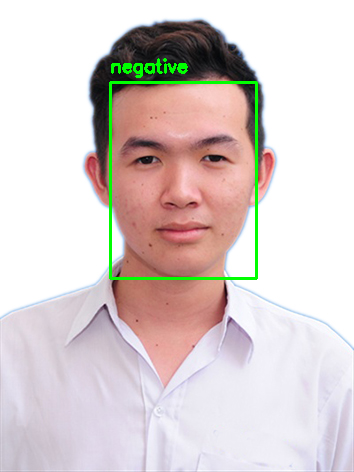

In [ ]:
file_demo = "/content/MicrosoftTeams-image (13).png"

print("Loading...")
demo_img = cv2.imread(file_demo)
print("Detecting faces....")

try:
  boxes, confi= detector.detect(demo_img)
  face_aligned_demos = []
  print(len(boxes))
  for box in boxes:
    face_aligned_demo = face_aligned(demo_img,box)  
    face_aligned_demos.append(face_aligned_demo)
  feas = compute_feature(face_aligned_demos)
  labels = svm.predict(feas)
  cv2_imshow(draw_boxes(demo_img,boxes, labels))
except:
  print("Không nhận diện được khuôn mặt trong hình")
  cv2_imshow(demo_img)


In [ ]:
# dir_demo = "/content/CS231/thoithoiimg/demo"
# files = os.listdir(dir_demo)
# print("Number of demo image:", len(files))
# for file in files:
#   file_name=os.path.join(dir_demo, file)
#   print(file_name)
#   try:
#     demo(file_name)
#   except:
#     print("error")


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import pickle
# filename = '/content/drive/MyDrive/UIT-ĐHCNTT/Năm 3/Nhapmonxulyanh/finalized_model.sav'
# pickle.dump(svm, open(filename, 'wb'))

# kết quả:

- Trước khi sử dụng face aligned: 86.73%
- Sau khi dử dụng face aligned: 97.5%
- Sau khi cân bằng histogram + facealign 96.35%
- Sau khi sử dụng tự động cân bằng sáng + face align: 97.99%
- Clahe: 95.77%
- Clahe+ auto: 96.28%

Dữ liệu:
- 234 tấm ảnh cho mô hình mtcnn
  - 71 pos (chiếm ..%)
  - 163 neg
- 500 ảnh cho mô hình svm
  - 100 pos
  - 300 neg
- Bộ ảnh demo

 - 50 tấm
   - 25 pos
   - 25 neg

- Train model:    
 - train: 80%
 - test: 20% 

- Hyperparmeter
  - C = ?
  - gamma = ?
  - kernel model

Các phần chính
- Giới thiệu bài toán 5p
 - Mô tả bài toán
 - Dữ liệu
 - Mô hình sử dụng (Mtcnn, facealigned, SVM)
- Tổng quan các mô hình sử dụng 2p
- Các hướng tiếp cận vấn đề 3p
- Train model 
- Tinh chỉnh model
- Kết quả
- Phân tích kết quả: 3p
- Kết luận: 

#Tài liệu tham khảo
https://helpex.vn/question/tu-dong-dieu-chinh-do-tuong-phan-va-do-sang-cua-anh-mau-tren-to-giay-voi-opencv-60c2e91b9f28385abef5d5ae
https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/